# Linear Models for Semantic Similarity Predictions

Dataset: [Semantic Similarity Predictions for Phrases in U.S. Patents](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching)

This notebook contains first-cut analysis & linear similarity prediction models

### Approach
---

The goal of the dataset is to predict the semantic similarity score ($s \in [0.00, 0.25, 0.50, 0.75, 1.00]$) between an anchor phrase and a target phrase, with 0 being completely unrelated and 1 being closely related.

After performing exploratory data analysis, a few important observations can be made:

* Phrases themselves are relatively short (~2 words) with the majority of phrase pairs not sharing any words, thus, simple methods such as the distance between pairs of bag-of-words or TF-IDF vectors will not perform well.

* Similarity scores are on a scale of 0 to 1, but also grouped into 5 discrete buckets, thus, the problem can be cast as both a regression or multiclass classification problem.

This notebook will attempt to predict the similarity score using the following algorithms:

* Linear Regression, Logistic Regression

with the following feature engineering approaches:

* Levenshtein distance (e.g. edit distance) b/t anchor & target phrase as the feature

* Various permutations of pre-trained spaCy word vectors as the features (avg, multiply, cosine similarity, etc.)

* Various permutations of custom-trained word vectors as the features (Refer to: train-patents-embeddings.ipynb)

### Preprocessing
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Levenshtein import distance as edit_dist

from gensim.models import Word2Vec, FastText

from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_train_val = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_titles = pd.read_csv('./data/titles.csv')

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

In [3]:
lm = WordNetLemmatizer()
ps = PorterStemmer()

def lemmatize(text):
    return lm.lemmatize(text)

def stem(text):
    return ps.stem(text)

def remove_stopwords(tokens):
    tokens = [token.lower().strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    return filtered_tokens

def preprocess(sent, method='lem'):
    tokens = word_tokenize(sent)
    filtered_tokens = remove_stopwords(tokens)
    
    if method == 'lem':
        tokens = [lemmatize(token) for token in filtered_tokens]
    else:
        tokens = [stem(token) for token in filtered_tokens]

    return ' '.join(tokens)

In [4]:
%%time
df_train['preproc_anchor'] = df_train['anchor'].apply(lambda x: preprocess(x))
df_train['preproc_target'] = df_train['target'].apply(lambda x: preprocess(x))

df_val['preproc_anchor'] = df_val['anchor'].apply(lambda x: preprocess(x))
df_val['preproc_target'] = df_val['target'].apply(lambda x: preprocess(x))

CPU times: user 9.45 s, sys: 1.13 s, total: 10.6 s
Wall time: 10.6 s


### Helper Functions
---

In [5]:
rmse_cols = ['feature_eng_method', 'regression_model', 'r2_score', 'rmse']
df_rmse = pd.DataFrame(columns=rmse_cols)

In [6]:
auroc = ['auroc_%.2f' % x for x in np.linspace(0, 1, 5)]
aupr = ['aupr_%.2f' % x for x in np.linspace(0, 1, 5)]
avg = ['avg_auroc', 'avg_aupr']
auc_cols = [x for sublist in [['feature_eng_method'], auroc, aupr, avg] for x in sublist]

df_auc = pd.DataFrame(columns=auc_cols)

In [7]:
def return_scores(y_val, y_pred, print_output=True):
    r2s = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if print_output:
        print("R^2 Score: %.4f" % r2s)
        print("RMSE: %.4f" % rmse)
        print()
    return r2s, rmse


def fit_linear_models(X_train, y_train, X_val, y_val, feature_eng_method, print_output=True):
    scores = []

    # Linear Regression
    print('LINEAR REGRESSION:')
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    r2s, rmse = return_scores(y_val, y_pred, print_output=print_output)
    scores.append([feature_eng_method, 'linear', r2s, rmse])

    # Ridge Regression
    print('RIDGE REGRESSION:')
    rr = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0, 10.0])
    rr.fit(X_train, y_train.ravel())

    y_pred = rr.predict(X_val)
    r2s, rmse = return_scores(y_val, y_pred, print_output=print_output)
    scores.append([feature_eng_method, 'ridge', r2s, rmse])

    # ElasticNet
    print('ELASTICNET REGRESSION:')
    en = ElasticNetCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9])
    en.fit(X_train, y_train.ravel())

    y_pred = en.predict(X_val)
    r2s, rmse = return_scores(y_val, y_pred, print_output=print_output)
    scores.append([feature_eng_method, 'elastic_net', r2s, rmse])

    return scores

In [8]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):
    
    areas = []

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas.append(auc(fpr, tpr))
        ax.plot(fpr, tpr, label = 'Score = %.2f (AUC: %0.5f)'  % (lbl, areas[i]))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas


def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):

    areas = []

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas.append(auc(rc, pr))
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[i]))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas


def plot_auc(labels, values, title):
    plt.figure(figsize=(8, 5))
    fig = plt.bar([str('%.2f' % x) for x in labels], values)
    plt.xlabel('Label')
    plt.ylabel('AUC')
    plt.title(title)
    plt.bar_label(fig, fmt='%.4f')

In [9]:
def fit_log_model(X_train, y_train, X_val, y_val, labels, model_name, output_dir):
    
    clf = OneVsRestClassifier(LogisticRegressionCV(cv=5, random_state=1, Cs=[0.001, 0.1, 1, 10, 100, 1000], max_iter=300))
    clf.fit(X_train, y_train)

    y_pred = clf.predict_proba(X_val)

    auroc = plot_roc_auc(y_val, y_pred, labels, model_name, output_dir + '/roc-' + model_name + '.jpg')
    aupr = plot_precision_recall_auc(y_val, y_pred, labels, model_name, output_dir + '/pr-' + model_name + '.jpg')

    plot_auc(labels, auroc, 'AUROC')
    plot_auc(labels, aupr, 'AUPR')

    scores = [[model_name], auroc, aupr, [np.mean(auroc), np.mean(aupr)]]
    return [x for sublist in scores for x in sublist]

#### y_train

In [10]:
y_train = df_train['score'].to_numpy().reshape(-1, 1)
y_val = df_val['score'].to_numpy().reshape(-1, 1)

In [11]:
# Encode first before binarize, binarize doesnt supporting floating point classes (e.g., 0.00, 0.25, etc)
le = LabelEncoder()
y_train_enc = le.fit_transform(df_train['score'])
y_val_enc = le.transform(df_val['score'])

In [12]:
y_train_bin = label_binarize(y_train_enc, classes=np.arange(0, 5))
y_val_bin = label_binarize(y_val_enc, classes=np.arange(0, 5))

### Levenshtein Distance
---

In [13]:
def calc_dist(df):
    return edit_dist(df.iloc[0], df.iloc[1])

In [14]:
df_train['edit_dist'] = df_train[['preproc_anchor', 'preproc_target']].apply(calc_dist, axis=1)
df_val['edit_dist'] = df_val[['preproc_anchor', 'preproc_target']].apply(calc_dist, axis=1)

In [15]:
X_train_edit = df_train['edit_dist'].to_numpy().reshape(-1, 1)
X_val_edit = df_val['edit_dist'].to_numpy().reshape(-1, 1)

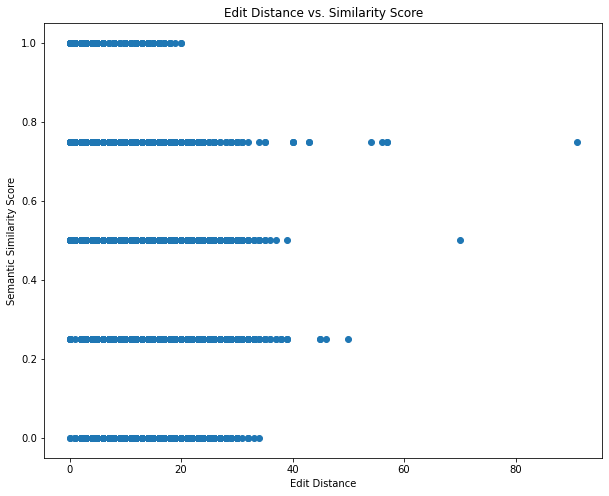

In [49]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X_train_edit, y_train)
plt.title('Edit Distance vs. Similarity Score');
plt.xlabel('Edit Distance');
plt.ylabel('Semantic Similarity Score');

#### Linear Regression

In [16]:
scores = fit_linear_models(X_train_edit, y_train, X_val_edit, y_val, feature_eng_method='edit_distance')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502

RIDGE REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502

ELASTICNET REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502



#### Logistic Regression

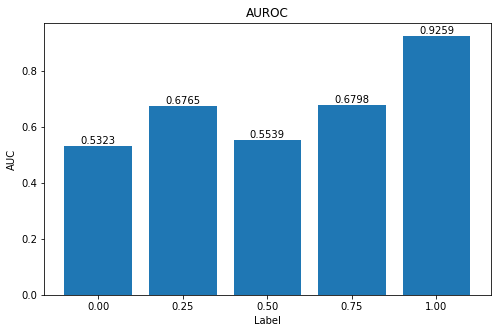

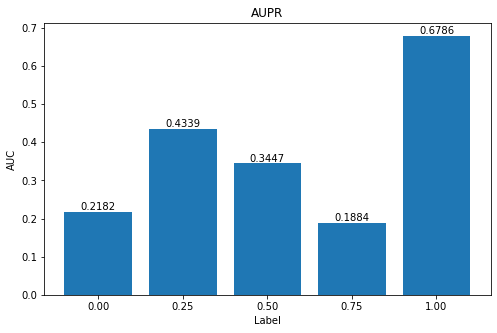

In [17]:
scores = fit_log_model(X_train_edit, y_train_bin, X_val_edit, y_val_bin, labels=np.linspace(0, 1, 5), model_name='edit_distance', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

### Pre-trained spaCy Model
---

Word embeddings (or word vectors) are learned, mathematical representations of words. With word embeddings, similar words have similar representations, thus, the idea explored in the following section is to use word embeddings to measure semantic similarity between the anchor and target phrase.

This is done through a few different methods:
* Multiplication - element-by-element, treat as feature vector

* Cosine Similarity & Euclidean Distance - use as measure of similarity (directly scale values to [0, 1] to use as y_pred)

The idea is illustrated in the diagram below.

<div>
<img src="./data/diagram.jpg" width="800"/>
</div>

In [18]:
nlp = spacy.load('en_core_web_lg')

def get_feature_vecs(df, model, vec_len=100, model_type='spacy'):
    mult = np.empty((0, vec_len), np.float32)
    cos_sim = np.empty((0, 0), np.float32)
    euc_dist = np.empty((0, 0), np.float32)

    for ind, row in df.iterrows():
        anchor_phrase = row['preproc_anchor']
        target_phrase = row['preproc_target']

        if model_type == 'spacy':
            anchor_vecs = np.array([nlp(word).vector for word in anchor_phrase.split(' ')])
            target_vecs = np.array([nlp(word).vector for word in target_phrase.split(' ')])
        elif model_type == 'gensim':
            anchor_vecs = np.array([model.wv[word] for word in anchor_phrase.split(' ')])
            target_vecs = np.array([model.wv[word] for word in target_phrase.split(' ')])
        
        avg_anchor_vecs = np.average(anchor_vecs, axis=0).reshape(1, -1)
        avg_target_vecs = np.average(target_vecs, axis=0).reshape(1, -1)

        feature_vec = np.multiply(avg_anchor_vecs, avg_target_vecs)

        mult = np.append(mult, feature_vec.reshape(1, vec_len), axis=0)
        cos_sim = np.append(cos_sim, cosine_similarity(avg_anchor_vecs, avg_target_vecs).flatten())
        euc_dist = np.append(euc_dist, np.sqrt(np.sum(np.square(avg_anchor_vecs - avg_target_vecs))))

    return mult, cos_sim.reshape(-1, 1), euc_dist.reshape(-1, 1)

In [19]:
%%time
X_train_mult, X_train_cos, X_train_euc = get_feature_vecs(df_train, nlp, vec_len=300)
X_val_mult, X_val_cos, X_val_euc = get_feature_vecs(df_val, nlp, vec_len=300)

CPU times: user 6min 23s, sys: 34.1 s, total: 6min 57s
Wall time: 6min 57s


#### Linear Regression

In [20]:
scores = fit_linear_models(X_train_mult, y_train, X_val_mult, y_val, feature_eng_method='spacy_vec_mult')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: 0.1787
RMSE: 0.2371

RIDGE REGRESSION:
R^2 Score: 0.1797
RMSE: 0.2369

ELASTICNET REGRESSION:
R^2 Score: 0.1781
RMSE: 0.2371



In [21]:
scores = fit_linear_models(X_train_cos, y_train, X_val_cos, y_val, feature_eng_method='spacy_vec_cos')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: 0.1795
RMSE: 0.2370

RIDGE REGRESSION:
R^2 Score: 0.1795
RMSE: 0.2370

ELASTICNET REGRESSION:
R^2 Score: 0.1792
RMSE: 0.2370



In [22]:
scores = fit_linear_models(X_train_euc, y_train, X_val_euc, y_val, feature_eng_method='spacy_vec_euc')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: 0.2286
RMSE: 0.2298

RIDGE REGRESSION:
R^2 Score: 0.2286
RMSE: 0.2298

ELASTICNET REGRESSION:
R^2 Score: 0.2285
RMSE: 0.2298



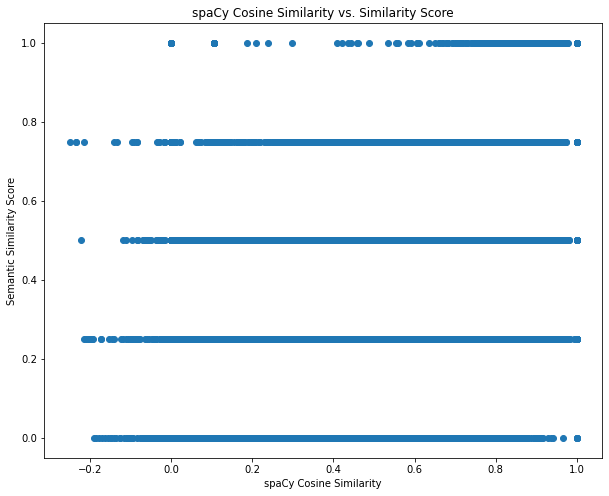

In [50]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X_train_cos, y_train)
plt.title('spaCy Cosine Similarity vs. Similarity Score');
plt.xlabel('spaCy Cosine Similarity');
plt.ylabel('Semantic Similarity Score');

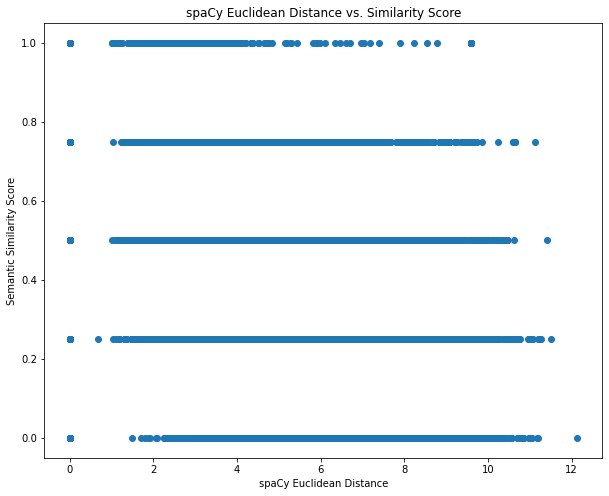

In [52]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X_train_euc, y_train)
plt.title('spaCy Euclidean Distance vs. Similarity Score');
plt.xlabel('spaCy Euclidean Distance');
plt.ylabel('Semantic Similarity Score');

#### Logistic Regression

In [23]:
# X_train_scaled used for numerical stability, X_train has trouble converging
sc = StandardScaler()
X_train_mult_scaled = sc.fit_transform(X_train_mult)
X_val_mult_scaled = sc.transform(X_val_mult)

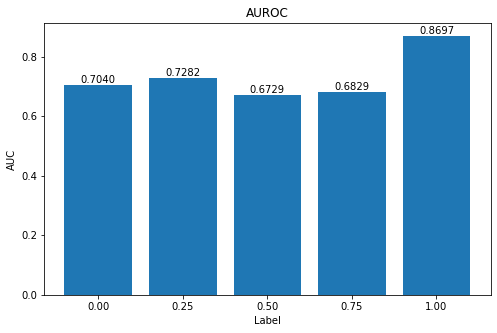

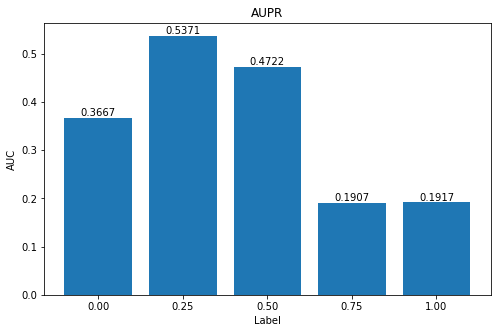

In [24]:
scores = fit_log_model(X_train_mult_scaled, y_train_bin, X_val_mult_scaled, y_val_bin, labels=np.linspace(0, 1, 5), model_name='spacy_vec_mult', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

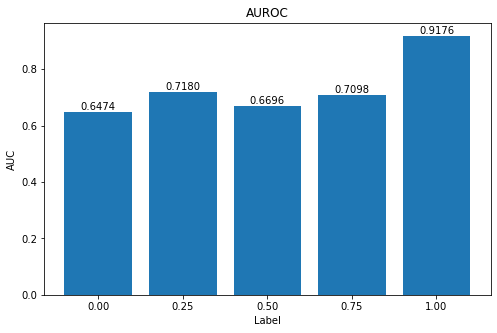

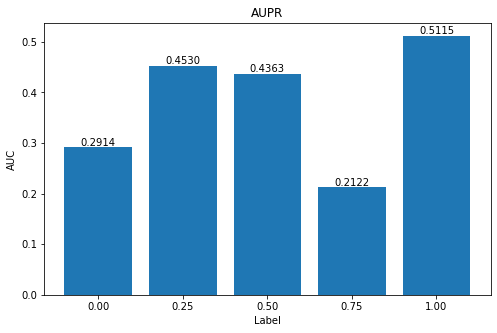

In [25]:
scores = fit_log_model(X_train_cos, y_train_bin, X_val_cos, y_val_bin, labels=np.linspace(0, 1, 5), model_name='spacy_vec_cos', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

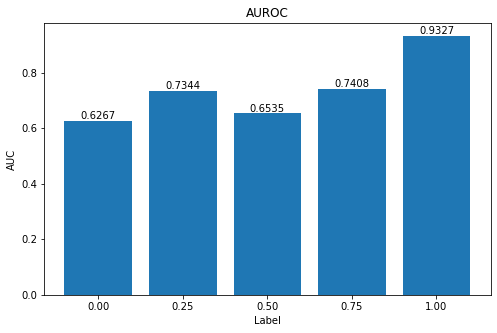

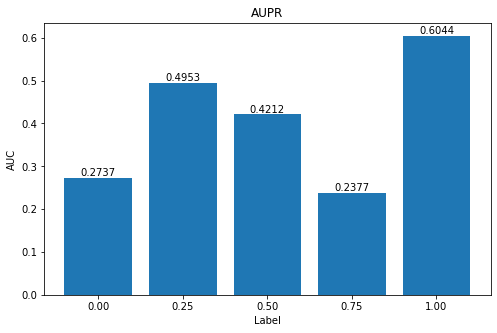

In [26]:
scores = fit_log_model(X_train_euc, y_train_bin, X_val_euc, y_val_bin, labels=np.linspace(0, 1, 5), model_name='spacy_vec_euc', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

### Custom Trained Word Vectors (gensim)
---

Refer to train-patents-embeddings.ipynb for details on word vector training process

In [27]:
unique_anchor_words = set()
unique_target_words = set()

df_train['preproc_anchor'].str.split().apply(unique_anchor_words.update)
df_train['preproc_target'].str.split().apply(unique_target_words.update)
unique_train_words = unique_anchor_words.union(unique_target_words)

In [28]:
def check_vocab(model, train_vocab):
    oov = []
    iv = []
    i = 0
    for word in train_vocab:
        try:
            vec = model.wv[word]
            iv.append(word)
        except:
            oov.append(word)

        i += 1

    print('Total Train Vocab: %i' % len(train_vocab))
    print('In-vocab: %i' % len(iv))
    print('Out-of-Vocab: %i' % len(oov))

In [29]:
model = Word2Vec.load(r'./models/patents-2022-w2v.model')
check_vocab(model, unique_train_words)

Total Train Vocab: 7191
In-vocab: 22
Out-of-Vocab: 7169


In [30]:
model = Word2Vec.load(r'./models/patents-2022-w2v-ngram.model')
check_vocab(model, unique_train_words)

Total Train Vocab: 7191
In-vocab: 22
Out-of-Vocab: 7169


In [31]:
ft_model = FastText.load(r'./models/patents-2022-fasttext.model')
check_vocab(ft_model, unique_train_words)

Total Train Vocab: 7191
In-vocab: 7191
Out-of-Vocab: 0


__Observations__

* As shown above, the word2vec models are unusable since the corpus it was trained on was relatively small (~6 months worth of patents). This results in only 22 words being in-vocab.

* The FastText model uses a subword model, thus, it will always return a word vector. 

In [32]:
%%time
X_train_mult_custom, X_train_cos_custom, X_train_euc_custom = get_feature_vecs(df_train, ft_model, vec_len=100, model_type='gensim')
X_val_mult_custom, X_val_cos_custom, X_val_euc_custom = get_feature_vecs(df_val, ft_model, vec_len=100, model_type='gensim')

CPU times: user 12.1 s, sys: 8.79 s, total: 20.9 s
Wall time: 20.9 s


#### Linear Regression

In [33]:
scores = fit_linear_models(X_train_mult_custom, y_train, X_val_mult_custom, y_val, feature_eng_method='gensim_vec_mult')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: -5.9379
RMSE: 0.6890

RIDGE REGRESSION:
R^2 Score: 0.0001
RMSE: 0.2616

ELASTICNET REGRESSION:
R^2 Score: -0.0001
RMSE: 0.2616



In [34]:
scores = fit_linear_models(X_train_cos_custom, y_train, X_val_cos_custom, y_val, feature_eng_method='gensim_vec_cos')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: 0.1676
RMSE: 0.2387

RIDGE REGRESSION:
R^2 Score: 0.1676
RMSE: 0.2387

ELASTICNET REGRESSION:
R^2 Score: 0.1675
RMSE: 0.2387



In [35]:
scores = fit_linear_models(X_train_euc_custom, y_train, X_val_euc_custom, y_val, feature_eng_method='gensim_vec_euc')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

LINEAR REGRESSION:
R^2 Score: -0.0006
RMSE: 0.2617

RIDGE REGRESSION:
R^2 Score: -0.0006
RMSE: 0.2617

ELASTICNET REGRESSION:
R^2 Score: -0.0005
RMSE: 0.2617



#### Logistic Regression

In [36]:
# X_train_scaled used for numerical stability, X_train has trouble converging
sc = StandardScaler()
X_train_mult_custom_scaled = sc.fit_transform(X_train_mult_custom)
X_val_mult_custom_scaled = sc.transform(X_val_mult_custom)

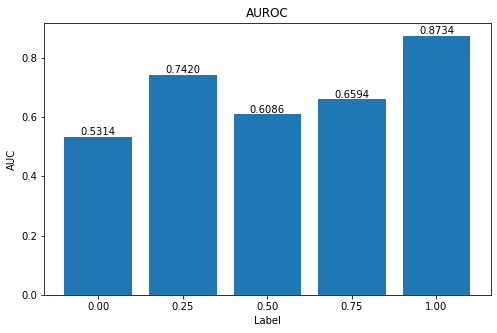

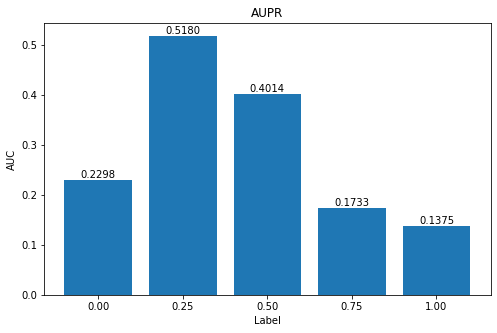

In [37]:
scores = fit_log_model(
    X_train_mult_custom_scaled, y_train_bin, X_val_mult_custom_scaled, y_val_bin, 
    labels=np.linspace(0, 1, 5), model_name='gensim_vec_mult', output_dir=r'./results/'
    )

df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

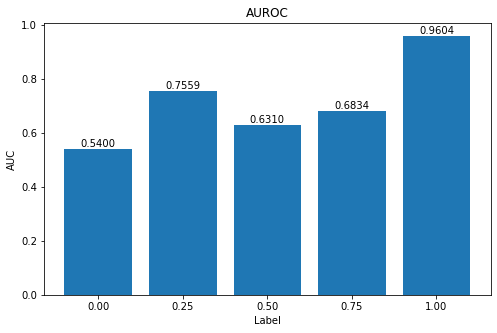

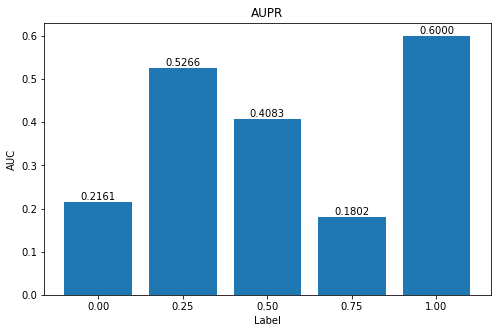

In [38]:
scores = fit_log_model(
    X_train_cos_custom, y_train_bin, X_val_cos_custom, y_val_bin, 
    labels=np.linspace(0, 1, 5), model_name='gensim_vec_cos', output_dir=r'./results/'
    )

df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

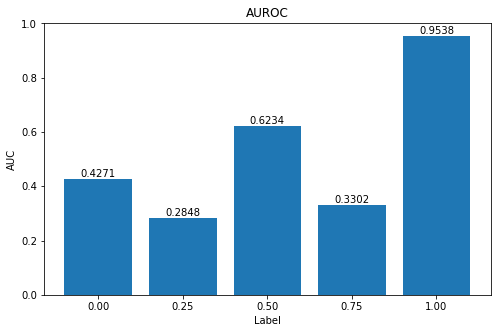

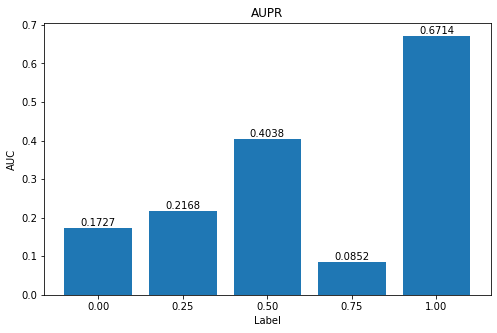

In [39]:
scores = fit_log_model(
    X_train_euc_custom, y_train_bin, X_val_euc_custom, y_val_bin, 
    labels=np.linspace(0, 1, 5), model_name='gensim_vec_euc', output_dir=r'./results/'
    )

df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

In [41]:
pd.set_option('display.max_rows', 1000)
display(df_rmse)

,feature_eng_method,regression_model,r2_score,rmse
0,edit_distance,linear,0.085168,0.250204
1,edit_distance,ridge,0.085168,0.250204
2,edit_distance,elastic_net,0.085165,0.250204
0,spacy_vec_mult,linear,0.17873,0.237064
1,spacy_vec_mult,ridge,0.17969,0.236926
2,spacy_vec_mult,elastic_net,0.178148,0.237148
0,spacy_vec_cos,linear,0.179477,0.236957
1,spacy_vec_cos,ridge,0.17947,0.236958
2,spacy_vec_cos,elastic_net,0.179191,0.236998
0,spacy_vec_euc,linear,0.228557,0.22976


In [43]:
pd.set_option('display.max_rows', 1000)
display(df_auc)

,feature_eng_method,auroc_0.00,auroc_0.25,auroc_0.50,auroc_0.75,auroc_1.00,aupr_0.00,aupr_0.25,aupr_0.50,aupr_0.75,aupr_1.00,avg_auroc,avg_aupr
0,edit_distance,0.532272,0.676478,0.553923,0.679756,0.925905,0.218208,0.433912,0.344697,0.188444,0.678636,0.673667,0.372779
0,spacy_vec_mult,0.704035,0.728201,0.67285,0.682937,0.869745,0.366669,0.537146,0.472205,0.190686,0.191657,0.731553,0.351673
0,spacy_vec_cos,0.647416,0.718023,0.669624,0.709833,0.917608,0.291446,0.45304,0.436281,0.212217,0.51149,0.732501,0.380895
0,spacy_vec_euc,0.626696,0.734421,0.653519,0.740801,0.932732,0.273665,0.495341,0.421242,0.237666,0.604372,0.737634,0.406457
0,gensim_vec_mult,0.531442,0.741989,0.608647,0.659439,0.873379,0.2298,0.518022,0.401377,0.173269,0.137545,0.682979,0.292003
0,gensim_vec_cos,0.540034,0.755946,0.631037,0.683371,0.960412,0.216086,0.526594,0.408347,0.180156,0.599973,0.71416,0.386231
0,gensim_vec_euc,0.427055,0.284794,0.623395,0.330208,0.953777,0.172717,0.216839,0.403815,0.085234,0.671361,0.523846,0.309993


In [44]:
df_rmse.to_csv(r'./results/lin_reg_results.csv')
df_auc.to_csv(r'./results/log_reg_results.csv')

### Conclusions
---

* Posing the 